# First Experiment Analysis - March 24

## Limitations of current experiment state

- Cursor experiment GUI is only set to have targets at the top of the screen
- Green feedback when target reached, but doesn't stop that trial
- Cursor can "fall off" the edges of the GUI
- Pre-experiment average can vary significantly and affect results
- No "score keeping" output
- No annotations/events in file to aid in epoching
- No rejection parameters for PSD result

In [1]:
import mne
import numpy as np

In [2]:
import os

def read_experiment_data(data_filename: str) -> mne.io.RawArray:
    with open(os.path.join('..', 'data', data_filename), 'r') as data_file:
        file_lines = data_file.readlines()

    sample_lines = file_lines[5:]  # skip header and bad first sample

    electrodes = [[] for _ in range(8)]  # 2d array - list of list of sample values
    for line in sample_lines:
        all_electrodes = line.split(',')[1:9]
        for idx, electrode_datum in enumerate(all_electrodes):
            electrodes[idx].append(electrode_datum)

    numpy_electrode_data = np.array(electrodes)
    print(f"Read from file with data shape: {numpy_electrode_data.shape}")

    samp_freq = 250
    channel_types = ['eeg' for _ in range(8)]
    channel_names = ["o1", "c3", "fp2", "fp1", "c4", "cz", "fz", "o2"]
    info = mne.create_info(ch_names=channel_names, sfreq=samp_freq, ch_types=channel_types)
    print(info)

    raw = mne.io.RawArray(numpy_electrode_data, info)
    return raw

### Read data file and apply standard pre-processing

- Bandpass .5-125 Hz
- Power line notch filter at 60 Hz and 120 Hz harmonic

Read from file with data shape: (8, 41238)
<Info | 7 non-empty values
 bads: []
 ch_names: o1, c3, fp2, fp1, c4, cz, fz, o2
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>
Creating RawArray with float64 data, n_channels=8, n_times=41238
    Range : 0 ... 41237 =      0.000 ...   164.948 secs
Ready.
Effective window size : 5.004 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

<ipython-input-3-daddb161968a>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=5, tmax=10)
<ipython-input-3-daddb161968a>:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmin=5, tmax=10)


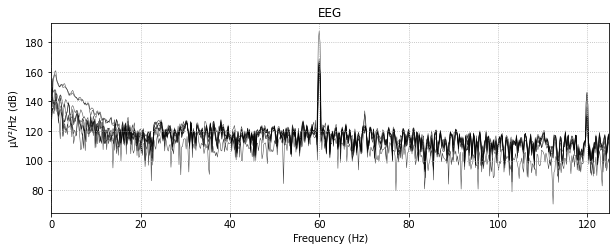

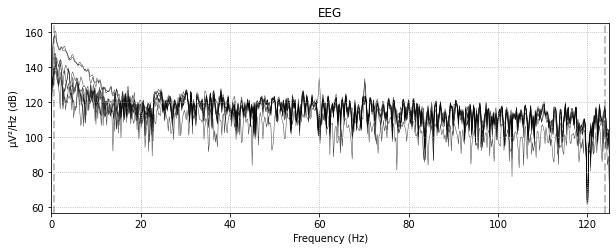

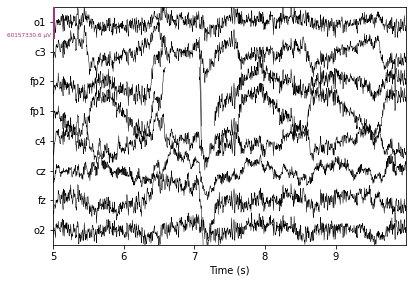

In [3]:
raw = read_experiment_data('experiment-avg1.7-2021-03-24T12:05:56.214528.txt')
raw.plot_psd(tmin=5, tmax=10)
raw.notch_filter(freqs=(60, 120))
raw.filter(l_freq=.5, h_freq=124)
raw.plot_psd(tmin=5, tmax=10)
_ = raw.plot(start=5, duration=5, scalings='auto', show_scrollbars=False, title="5s of filtered data")

### Effect of window size in PSD calculated by the Welch method

Window widths of roughly .25, 1, 2, and 4 seconds. Window overlap of 50%.

Resource: https://sapienlabs.org/factors-that-impact-power-spectrum-density-estimation/

In [4]:
import brainflow

In [8]:
c3_5s = raw.get_data(picks=['c3'], start=(250 * 5), stop=(250 * 10))[0]  # 5->10 seconds
print(f"Number of c3 samples: {len(c3_5s)}")

psd_results = []
windows = (64, 256, 512, 1024)
for window_size_samples in windows:  # corresponds to roughly .25, 1, 2, and 4 seconds at 250 Hz samp rate
    psd_results.append(brainflow.DataFilter.get_psd_welch(
        c3_5s,
        nfft=window_size_samples,
        overlap=window_size_samples // 2,
        sampling_rate=250,
        window=brainflow.WindowFunctions.BLACKMAN_HARRIS.value
    ))

Number of c3 samples: 1250


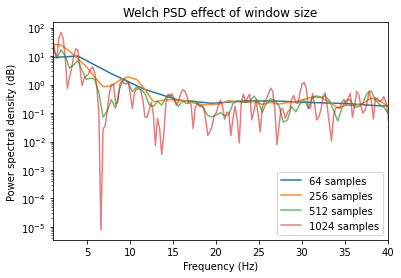

In [10]:
import matplotlib.pyplot as plt

plt.subplot(1, 1, 1)
alphas = [1, .9, .7, .6]

for result, window_size, alpha in zip(psd_results, windows, alphas):
    freq = result[1]
    value = result[0]
    plt.plot(freq, value, label=f"{window_size} samples", alpha=alpha)

plt.title("Welch PSD effect of window size")
plt.yscale("log")
plt.xlim(1,40)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density (dB)")
plt.legend()
plt.show()